# Spacetime Ripple Simulation with Relativistic Effects

This notebook demonstrates the behavior of particles and wave functions in a 4D spacetime grid. It includes:
- Converting between 4D spherical and Cartesian coordinates.
- Simulating wave propagation.
- Modeling particle paths with relativistic effects.
- Visualizing results.

In [77]:
# Import Required Libraries
from scipy.constants import c as speed_of_light
from numba import njit
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline


## Define StateSpace Class
This class contains functions for:
- Converting between 4D spherical and Cartesian coordinates.
- Computing relativistic effects such as time dilation and wave propagation.
- Modeling spin and antiparticle wave functions.

In [235]:
class QuantumWaveSimulator:
    def __init__(self, L, T, c, dx, dt, m=0):
        """
        Initialize simulation parameters.
        """
        self.L = L  # Length of spatial domain
        self.T = T  # Total simulation time
        self.c = c  # Speed of light
        self.dx = dx  # Spatial resolution
        self.dt = dt  # Time step size
        self.m = m  # Mass term

        self.nx = int(L / dx) + 1
        self.nt = int(T / dt) + 1

        self.x = np.linspace(-L / 2, L / 2, self.nx)  # Spatial grid
        self.t = np.linspace(0, T, self.nt)  # Time grid

        # Wavefunction initialization
        self.Psi = np.zeros((self.nt, self.nx))  # Wavefunction for Klein-Gordon

        self.energy = np.zeros(self.nt)  # Total energy over time

    def initialize_particle(self, mode="single", A=1, k=2 * np.pi, phi=0):
        """
        Initialize the wavefunction based on the specified mode.
        """
        # Klein-Gordon wavefunction is scalar
        if mode == "single":
            self.Psi[0, :] = A * np.exp(-0.5 * (self.x / self.L) ** 2) * np.cos(k * self.x + phi)
        elif mode == "entangled":
            # Example: Two entangled Gaussian peaks
            self.Psi[0, :] = (
                A * np.exp(-0.5 * ((self.x - self.L / 4)) ** 2) +
                A * np.exp(-0.5 * ((self.x + self.L / 4)) ** 2)
            )
        elif mode == "superposition":
            # Superposition of left- and right-moving components
            self.Psi[0, :] = (
                A * np.cos(k * self.x + phi) + A * np.cos(-k * self.x + phi)
            )
        else:
            raise ValueError("Mode must be 'single', 'entangled', or 'superposition'.")    
        self.Psi[1, :] = (
            self.Psi[0, :] + self.dt * self.initial_wave_velocity(self.x, A=A, k=k, phi=phi)
        )
        self.mode = mode

    def initial_wave_velocity(self, x, A=1, k=2 * np.pi, phi=0):
        """
        Initialize the wavefunction's time derivative.
        """
        return -A * self.c * k * np.sin(k * x + phi)
    
    @staticmethod
    @njit
    def solve_klein_gordon(Psi, nt, nx, c, dt, dx, m2):
        """
        Solve the Klein-Gordon equation.
        """
        for n in range(1, nt - 1):
            for i in range(1, nx - 1):
                Psi[n + 1, i] = (
                    2 * Psi[n, i]
                    - Psi[n - 1, i]
                    + (c * dt / dx) ** 2 * (Psi[n, i + 1] - 2 * Psi[n, i] + Psi[n, i - 1])
                    - (dt ** 2) * m2 * Psi[n, i]
                )

            # Check for numerical stability
            if np.any(np.isnan(Psi[n + 1, :])) or np.any(np.isinf(Psi[n + 1, :])):
                raise ValueError(f"Numerical instability detected at step {n}.")
        return Psi

    def solve(self):
        """
        Solve the selected equation (Klein-Gordon or Dirac).
        """
        m2 = (self.m / self.c) ** 2
        self.Psi = self.solve_klein_gordon(self.Psi, self.nt, self.nx, self.c, self.dt, self.dx, m2)
        self.compute_energy()
        
    def compute_energy(self):
        """
        Compute and store the total energy of the system over time.
        """
        for n in range(1, self.nt - 1):
            # Kinetic energy
            time_derivative = (self.Psi[n + 1, :] - self.Psi[n - 1, :]) / (2 * self.dt)
            kinetic_energy = 0.5 * time_derivative ** 2

            # Potential energy
            space_derivative = np.zeros_like(self.Psi[n, :])
            space_derivative[1:-1] = (self.Psi[n, 2:] - self.Psi[n, :-2]) / (2 * self.dx)
            potential_energy = 0.5 * (
                (self.c * space_derivative) ** 2 + self.m ** 2 * self.Psi[n, :] ** 2
            )

            # Total energy density
            self.energy[n] = np.sum(kinetic_energy + potential_energy) * self.dx  # Integrate over space
        # max_change = np.max(np.abs(np.diff(self.energy)))
        # print(f"Maximum Energy Change: {max_change:.2e}")
        # if max_change < 1e-3:
        #     print("Energy conservation validation passed!")
        # else:
        #     print("Energy conservation validation failed!")

    def visualize_wave(self, localize=True, show_phase=False):
        """
        Visualize the wavefunction over space and time.

        Parameters:
        - component: Choose which spinor component to visualize (0 or 1 for Dirac equation).
        - show_phase: If True, visualize the phase instead of the amplitude.
        - localize: If True, display localized wave amplitudes and conjugates.
        """
        plt.figure(figsize=(10, 6))
        
        if localize:
            forward_amplitude = (self.Psi) ** 2 if not show_phase else np.angle((self.Psi) )
            conjugate_amplitude = (np.conj(self.Psi) ** 2) if not show_phase else np.angle((np.conj(self.Psi)))
            cmap = 'plasma'
        else:
            forward_amplitude = (self.Psi) if not show_phase else np.angle(self.Psi)
            conjugate_amplitude = np.conj(self.Psi) if not show_phase else np.angle(np.conj(self.Psi))
            cmap = 'viridis'

        amplitude = np.concatenate(
            [-conjugate_amplitude[::-1, ::-1], forward_amplitude], axis=0
        )
        extent = [-self.L / 2, self.L / 2, -self.T, self.T]
        plt.imshow(
            amplitude,
            extent=extent,
            origin="lower",
            aspect="auto",
            cmap=cmap,
        )
        label = "|Ψ|^2" if localize else "|Ψ|"
        plt.colorbar(label=label)
        plt.xlabel("Position $x$")
        plt.ylabel("Time $t$")
        plt.title(f"{self.mode} Wavefunction Ψ - Wave Propagation")
        plt.show()

    def visualize_energy(self):
        """
        Plot the total energy over time from -T to T.
        """
        # Assuming self.t goes from 0 to T originally:
        T_max = self.t[-1]
        # Create a symmetric time array from -T to T
        t_sym = np.linspace(-T_max, T_max, 2 * len(self.t))
        
        # Construct a symmetric energy array:
        # Forward half (0 to T): self.energy
        # Negative half (-T to 0): We'll assume energy is even and mirror it.
        # If you have a reasoned definition for negative times, replace accordingly.
        energy_sym = np.concatenate((self.energy[::-1], self.energy))
        
        plt.figure(figsize=(8, 5))
        plt.plot(t_sym, energy_sym, label="Total Energy", color="blue")
        plt.xlabel("Time $t$")
        plt.ylabel(f"{self.mode} Wavefunction Ψ - Total Energy $E(t)$")
        plt.title("Energy Conservation from -T to T")
        plt.legend()
        plt.grid()
        plt.show()

    def visualize_2D_ripple_polar(self, localize=True, show_phase=False):
        """
        Create a 2D polar ripple visualization from -T to T.
        - 0° to 180°: forward wavefunction (t>0)
        - 180° to 360°: time-reversed (conjugate) wavefunction (t<0)
        """
        # Original maximum time
        T_max = self.t[-1]
        # We'll sample times more sparsely for visualization
        sample_rate = self.nt // 50
        if sample_rate == 0:
            sample_rate = 1
        # Original positive time steps
        time_steps = np.arange(0, self.nt, sample_rate)
        
        # Create a symmetric time array from -T to T
        # Double length: first half for negative times, second for positive
        t_sym = np.linspace(0, T_max, len(time_steps))
        # Polar angle from 0 to 2*pi
        theta = np.linspace(0, 2 * np.pi, self.nx * 2)
        
        # Radius corresponds to |t|; if we consider radius as c*t, then negative times
        # will just reflect inward vs. outward. Typically radius should be >=0, but
        # we can interpret negative times as traveling inward. For visualization,
        # we can just take the absolute value or show negative radius as going inward.
        r = self.c * t_sym
        R, TH = np.meshgrid(r, theta)
        
        # Allocate amplitude array
        amplitude = np.zeros((len(theta), len(t_sym)), dtype=complex)
        
        # We have data only for t>=0: self.Psi[t_step,:]
        # For negative times, we will use the conjugate of the corresponding positive time.
        half = len(time_steps)
        
        # Build a time index mapping:
        # t<0 will map to conjugate solution: Psi_conjugate(i) = conj(Psi(i))
        # t>0 will map to forward solution directly.
        for i, t_val in enumerate(t_sym):
            # Find the corresponding positive time index
            # Positive side: i from half to end maps directly to time_steps
            # Negative side: i from 0 to half-1 maps to time_steps in reverse order
            if t_val < 0:
                # Negative times: mirror index
                pos_idx = half - 1 - i  # This maps negative times backwards
                if pos_idx < 0:
                    pos_idx = 0
                forward_amp = (self.Psi[time_steps[pos_idx], :])**2
                conj_amp = (np.conj(self.Psi[time_steps[pos_idx], :]))**2
                # For negative times, use the conjugate amplitude as the dominant (antimatter) part
                if localize:
                    # Place conjugate amplitude in 180°-360° (self.nx: end)
                    amplitude[:self.nx, i] = -conj_amp[::-1] if not show_phase else np.angle(np.conj(self.Psi[time_steps[pos_idx], :])[::-1])
                    amplitude[self.nx:, i] = forward_amp[::-1] if not show_phase else -np.angle(self.Psi[time_steps[pos_idx], :])
                    cmap = 'plasma'
                else:
                    amplitude[:self.nx, i] = -np.conj(self.Psi[time_steps[pos_idx], :])[::-1] if not show_phase else -np.angle(np.conj(self.Psi[time_steps[pos_idx], :])[::-1])
                    amplitude[self.nx:, i] = self.Psi[time_steps[pos_idx], :][::-1] if not show_phase else np.angle(self.Psi[time_steps[pos_idx], :][::-1])
                    cmap = 'viridis'
            else:
                # Positive times
                pos_idx = i - half
                if pos_idx >= half:
                    pos_idx = half - 1
                forward_amp = (self.Psi[time_steps[pos_idx], :])**2
                conj_amp = (np.conj(self.Psi[time_steps[pos_idx], :]))**2
                # For positive times, use the forward amplitude in 0°-180°
                if localize:
                    amplitude[:self.nx, i] = forward_amp[::-1] if not show_phase else np.angle(self.Psi[time_steps[pos_idx], :])
                    amplitude[self.nx:, i] = -conj_amp[::-1] if not show_phase else -np.angle(np.conj(self.Psi[time_steps[pos_idx], :]))
                    cmap = 'plasma'
                else:
                    amplitude[:self.nx, i] = self.Psi[time_steps[pos_idx], :][::-1] if not show_phase else np.angle(self.Psi[time_steps[pos_idx], :][::-1])
                    amplitude[self.nx:, i] = -np.conj(self.Psi[time_steps[pos_idx], :])[::-1] if not show_phase else -np.angle(np.conj(self.Psi[time_steps[pos_idx], :])[::-1])
                    cmap = 'viridis'

        # Plot the 2D polar visualization
        fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(10, 8))
        c = ax.pcolormesh(TH, R, amplitude.real, shading='auto', cmap=cmap)
        fig.colorbar(c, ax=ax, label='Amplitude $|\Psi|^2$')
        ax.set_title(f"{self.mode} Wavefunction Ψ - 2D Polar Ripple (-T to T)")
        plt.show()


    def visualize_3D_ripple_polar(self, localize = True, show_phase=False):
        """
        Create a 3D polar ripple visualization with accurate amplitude mapping.
        Forward wavefunction occupies 0°-180°, and conjugate (antimatter) occupies 180°-360°.
        """
        fig = plt.figure(figsize=(12, 8))
        ax = fig.add_subplot(111, projection='3d')

        theta = np.linspace(0, 2 * np.pi, self.nx * 2)  # Full angular domain (0 to 360°)
        r = self.c * self.t  # Radius grows with time

        # Create a meshgrid for theta and time (radius)
        Theta, R = np.meshgrid(theta, r)
        
        # Compute amplitudes for forward and conjugate wavefunctions
        if localize:
            forward_amplitude = (self.Psi) ** 2 if not show_phase else np.angle(self.Psi)
            amplitude_conjugate = (np.conj(forward_amplitude)**2) if not show_phase else np.angle(np.conj(self.Psi))
            cmap = 'plasma'
        else:
            forward_amplitude =  (self.Psi) if not show_phase else np.angle(self.Psi)
            amplitude_conjugate = np.conj(forward_amplitude) if not show_phase else np.angle(np.conj(self.Psi))
            cmap = 'viridis'

        # Combine amplitudes for full 360° visualization
        amplitude_combined = np.concatenate(
            #[amplitude_forward, amplitude_conjugate[:, ::-1]], axis=1
            [forward_amplitude[:,::-1], -amplitude_conjugate[:, ::-1]], axis=1
        )
        
        # Convert polar coordinates to Cartesian
        X = R * np.cos(Theta)
        Y = R * np.sin(Theta)
        Z = amplitude_combined

        # Plot the surface
        surf = ax.plot_surface(
            X, Y, Z, cmap=cmap, edgecolor='none', alpha=0.8
        )
        
        # Add colorbar and labels
        fig.colorbar(surf, ax=ax, label='Amplitude $|\Psi|^2$')
        ax.set_title(f"{self.mode} Wavefunction Ψ - 3D Polar Ripple Visualization with Accurate Amplitude")
        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        ax.set_zlabel("Amplitude $|\Psi|^2$")
        plt.show()



## Simulate Wave Propagation
We solve the Klein-Gordon wave equation in 1D.

In [256]:

# --- Simulation Parameters ---
L =5  # Length of domain
T =10  # Total simulation time
c = 1  # Speed of light
dx = 0.01  # Spatial resolution
dt = dx / c  # Time step size
m = 1  # Mass term for Klein-Gordon equation
localize = True
show_phase= False

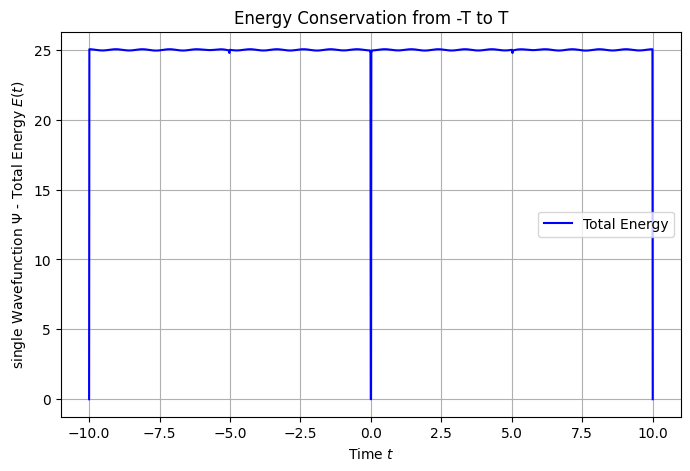

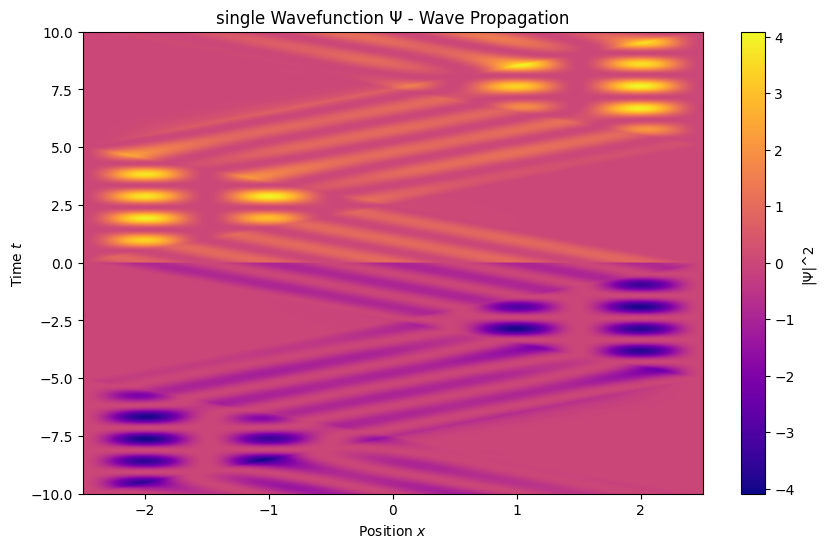

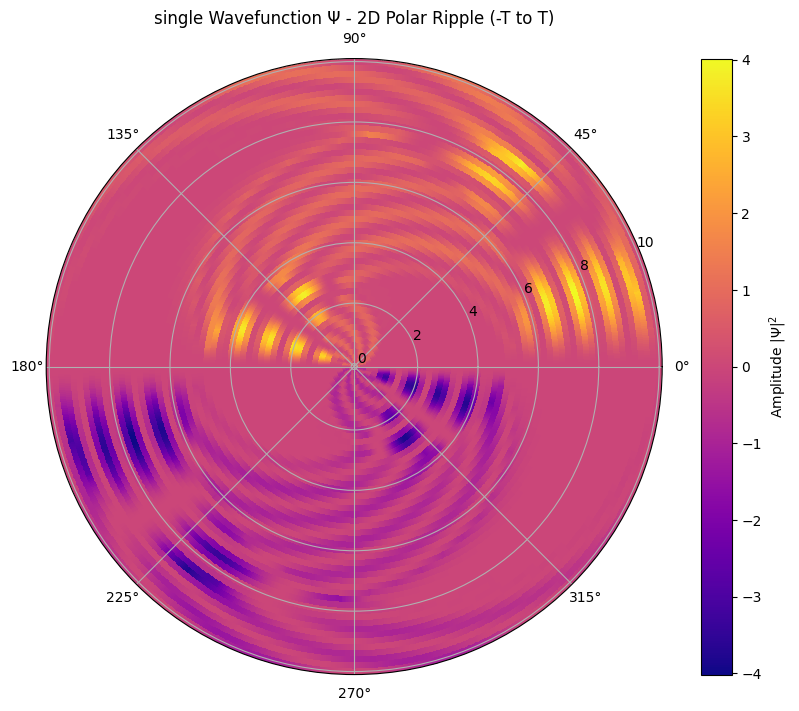

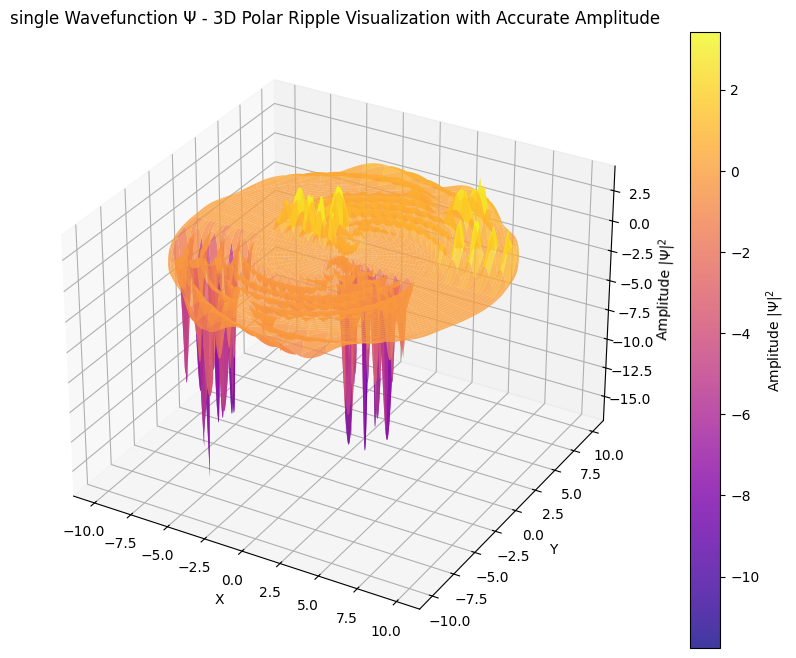

In [257]:
# Initialize the simulator for Klein-Gordon equation
kg_simulator = QuantumWaveSimulator(L=L, T=T, c=c, dx=dx, dt=dt, m=m)
kg_simulator.initialize_particle(mode="single", A=1, k=5* np.pi / 5, phi=0)
kg_simulator.solve()
kg_simulator.visualize_energy()
kg_simulator.visualize_wave(localize=localize,show_phase=show_phase)
kg_simulator.visualize_2D_ripple_polar(localize=localize,show_phase=show_phase)
kg_simulator.visualize_3D_ripple_polar(localize=localize,show_phase=show_phase)


# Time, Ripples, and Spacetime Geometry: A Probabilistic Model of Reality
## Abstract
In this work, we present a novel interpretation of spacetime and quantum mechanics, leveraging the concept of ripples as a framework for understanding probabilistic branching, energy propagation, and observer-based timelines. Our approach builds on foundational quantum wave equations, such as the Klein-Gordon equation, and explores its connection to the geometry of spacetime, decisions, and energy distributions over time. The ripple effect, interpreted as branching action states, provides an alternative visualization to the Many Worlds Interpretation. 

## Introduction
The Many Worlds Interpretation (MWI) of quantum mechanics has long provided a framework for understanding probabilistic outcomes in quantum systems. In this paper, we extend and reinterpret this idea by introducing the concept of ripples—a natural evolution of probabilistic branching in spacetime.

We explore:
- The geometric interpretation of ripples in 4D spacetime.
- The role of energy as a driving force for probabilistic evolution.
- Visualizations and simulations to validate and illustrate the model.

This interpretation posits that the evolution of events and decisions can be viewed as expanding ripples in spacetime, where the circumference of the ripple grows to include increasing sets of possible outcomes.

## Theoretical Background
The ripple model builds upon key concepts in quantum mechanics and spacetime geometry:
1. **Wavefunction and Klein-Gordon Equation**:
    - Wavefunction $`\Psi(x, t)`$ evolves according to the Klein-Gordon equation:
    $$
    \frac{\partial^2 \Psi}{\partial t^2} - c^2 \frac{\partial^2 \Psi}{\partial x^2} + m^2 c^4 \Psi = 0
    $$
2. **Probabilistic Branching**:
    - The probability density $`\Psi(x, t)|^2`$ represents the likelihood of being in a specific state.
3. **Ripples as Action States**:
    - Ripples represent the expanding set of possible action states, driven by energy propagation.

This framework offers a geometric way to visualize probabilistic evolution and its relationship to time, energy, and decisions.

## Mathematical Framework
The ripple model leverages the Klein-Gordon equation to evolve the wavefunction, with ripples representing probabilistic boundaries.

### Klein-Gordon Equation
We solve the Klein-Gordon equation numerically to model wavefunction evolution. The ripple radius $`r = ct`$ grows over time, representing increasing sets of action states.

### Probabilistic Energy Framework
Energy propagates outward with the ripple, influencing probabilities:
$$
E(t, r) \propto |\Psi(x, t)|^2 \cdot \exp\left(-\frac{x^2}{r^2}\right)
$$

## Simulations
We use numerical methods to simulate wavefunction evolution and visualize ripples in spacetime.

### Wavefunction Evolution
Below, we solve the Klein-Gordon equation and visualize wavefunction evolution:

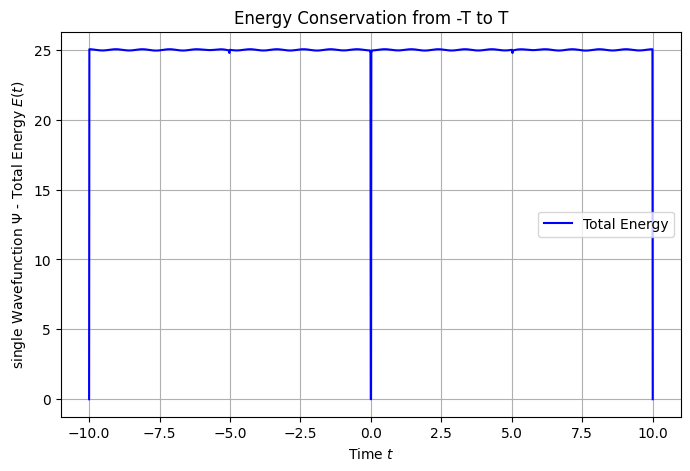

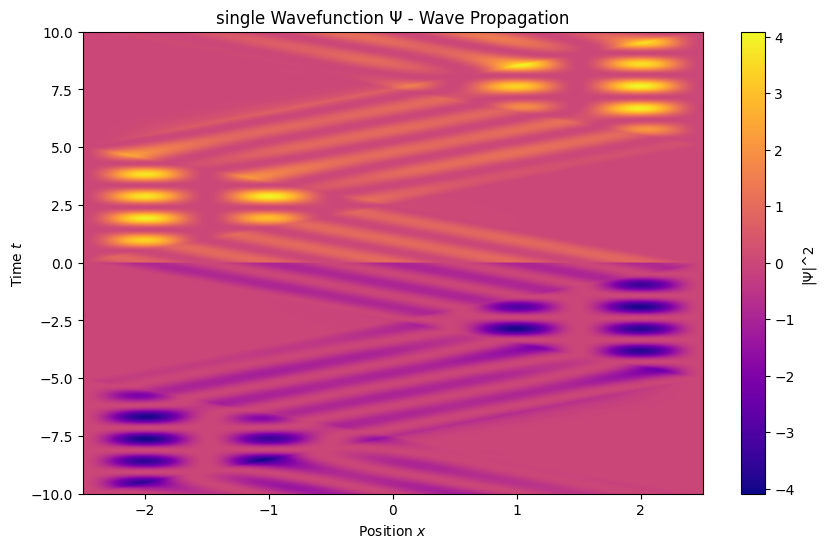

In [258]:
# Include code to solve the Klein-Gordon equation and visualize the wavefunction]
kg_simulator.visualize_energy()
kg_simulator.visualize_wave(localize=localize)

### Ripple Propagation
We visualize the ripple effect, showing how action states expand over time.

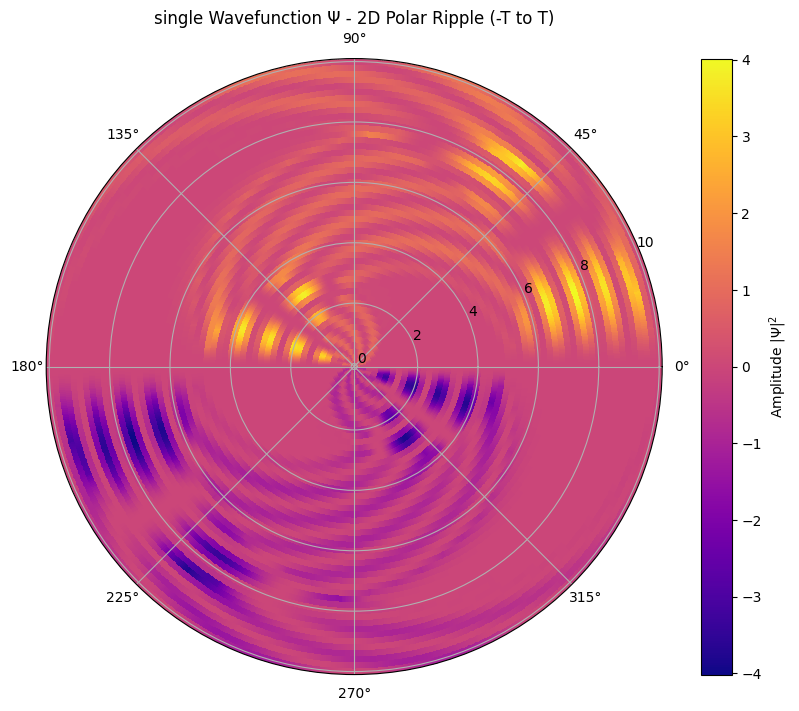

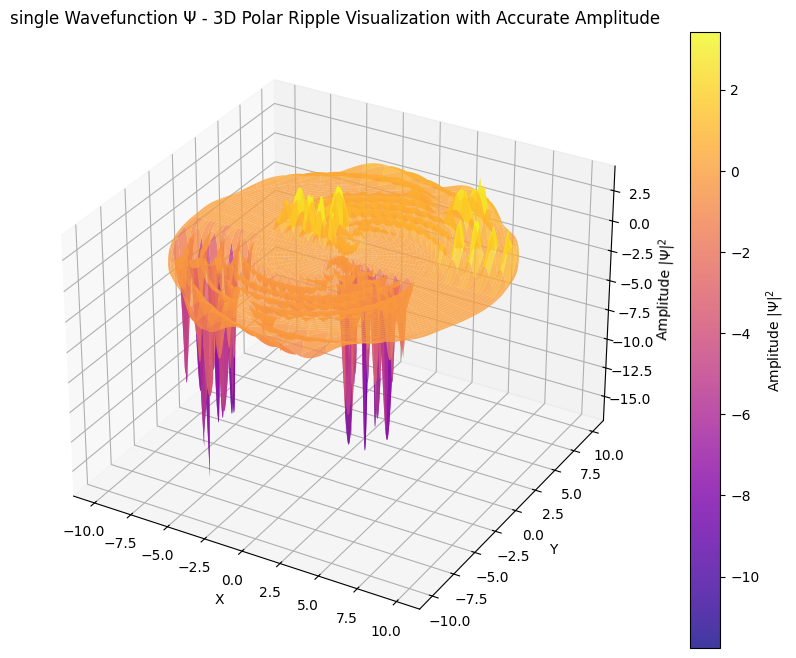

In [259]:
# Code for ripple visualization
kg_simulator.visualize_2D_ripple_polar(localize=localize)
kg_simulator.visualize_3D_ripple_polar(localize=localize)

## Results
1. **Wavefunction Evolution**:
    - The wavefunction evolves as expected under the Klein-Gordon equation.
    - Probability densities propagate outward, reflecting energy and action state distributions.

2. **Ripple Propagation**:
    - Ripples expand with time, increasing the circumference (action states).
    - Observers experience specific worldlines influenced by probabilistic energy transfer.

### Visualizations

## Discussion
The ripple model provides an intuitive way to visualize and understand probabilistic evolution in spacetime. Key insights include:
1. **Energy as the Driver**:
    - Energy propagates outward, influencing probabilities and decisions across timelines.
2. **Branching of Worlds**:
    - The circumference of the ripple grows with time, representing the increasing set of action states.

### Comparison to Many Worlds
Unlike the Many Worlds Interpretation, the ripple model emphasizes the role of energy and provides a geometric visualization of probabilistic evolution.

### Limitations and Next Steps
- Incorporate damping or loss to simulate energy dissipation.
- Extend the model to 2D or 3D for a more comprehensive view.
- Explore experimental setups to validate the model's predictions.

## Conclusion
The ripple model offers a new way to conceptualize probabilistic evolution in spacetime, emphasizing the role of energy and geometry. This approach bridges quantum mechanics and spacetime geometry, providing a visual and conceptual framework for understanding the branching of action states and timelines.

Future work will focus on validating this model through simulations, experiments, and mathematical proofs.

## References
- Dirac, P. A. M. *The Principles of Quantum Mechanics*.
- Everett, H. *"Relative State" Formulation of Quantum Mechanics*.
- Minkowski, H. *Space and Time*.